In [9]:
%load_ext autoreload
%autoreload 2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import argparse
import repackage

import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from experiment_utils import set_env, seed_everything
set_env()
from cgn_framework.mnists.generate_data import generate_cf_dataset, generate_dataset, get_dataloaders

# Train concept classifier for double-colored-MNIST
We need to train:
1. A CF for classifying the digit's color
2. A CF for classifying the digit's shape
3. A CF for background color

## Load dataset

In [11]:
dl_train, dl_test = get_dataloaders('double_colored_MNIST', batch_size=1000, workers=8)

### Dataset size

In [12]:
print(f"Train: {dl_train.dataset.labels.shape[0]}")
print(f"Test: {dl_test.dataset.labels.shape[0]}")

Train: 50000
Test: 10000


### Get a sample image

In [13]:
random_idx = np.random.randint(0, dl_train.dataset.labels.shape[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


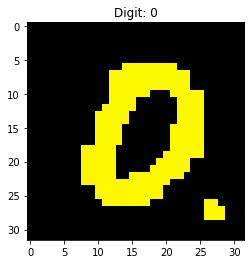

KeyError: 'bg_label'

In [14]:
plt.imshow(dl_train.dataset.__getitem__(random_idx)['ims'].transpose(0,1).transpose(1,2))
label = dl_train.dataset.__getitem__(random_idx)['labels']
plt.title(f"Digit: {label}")
plt.show()
print(f"BG label: {(dl_train.dataset.__getitem__(random_idx)['bg_label']*255).tolist()}")
print(f"Texture label: {(dl_train.dataset.__getitem__(random_idx)['texture_label']*255).tolist()}")

## Train color CF

In [15]:
from cgn_framework.mnists.models.classifier import CNN
from train_classifier import train, test

# Args for training
args = argparse.Namespace()
args.batch_size = 1000
args.gamma = 0.7
args.epochs = 10
args.lr = 1.0
args.log_interval = 100
args.dataset = 'double_colored_MNIST'

# Data
dl_train, dl_test = get_dataloaders(args.dataset, batch_size=args.batch_size, workers=8)

# Model
model = CNN()

# Optimizer
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

# push to device and train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [16]:
train_accs = dict()
test_accs = dict()
for epoch in range(1, args.epochs + 1):
    train_acc = train(args, model, device, dl_train, optimizer, epoch)
    test_acc = test(model, device, dl_test)
    train_accs[epoch] = train_acc
    test_accs[epoch] = test_acc
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.302454


KeyboardInterrupt: 

## Train shape CF

## Train background CF